## Testing training

- Installing dependencies

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import nibabel as nib
import random
import sys
import matplotlib.pyplot as plt

# Append the path to access custom modules
if '../' not in sys.path:
    sys.path.append('../')
    
torch.manual_seed(42)
random.seed(42)

import src.modules.training_settings as ts
import src.modules.trainer as t

from nilearn import plotting
from monai.data import CacheDataset, DataLoader
from monai.utils import first
from monai.transforms import (
	Compose,
	EnsureTyped,
	EnsureChannelFirstd,
	LoadImaged,
	NormalizeIntensityd,
	Orientationd,
    ConcatItemsd,
    ToTensord
)

2025-07-04 09:30:14.247525: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751621414.438114      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751621414.492959      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [8]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # for multi-GPU setups

# Example: setting a seed for reproducibility
set_seed(42)

In [9]:
def get_device():
	"""
	Returns the device available on the current machine.
	Args: None
	Returns:
		device (str): name of the device available.
	"""
	device = 'cpu'
	if torch.backends.mps.is_available():
		device = 'mps'
	elif torch.cuda.is_available():
		device = 'cuda'
        
	return device

- Read the datasets

In [ ]:
train_df = pd.read_csv('path/train.csv')
val_df = pd.read_csv('path/validation.csv')
test_df = pd.read_csv('path/test.csv')

- Setup the classification problem. There four configurations:
    1) type='binary' and subtype='CNvsAD'
    2) type='binary' and subtype='CNvsEarly'
    3) type='binary' and subtype='ADvsEarly'
    4) type='ternary' and subtype=''

- *Note*: to change the experiment, run the previous cell to re-read the datasets from csv and then change the `type` and `subtype` parameters of the method in the the subsequent cell

In [ ]:
train_df, val_df, test_df, _ = ts.set_classification_problem_dataframes(
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    type='ternary',
    subtype=''
)

- Get the dictionary datasets

In [17]:
train_set_dict = ts.get_datasets_dict(train_df, '/kaggle/input/datath/upload2/train_preprocess')
validation_set_dict = ts.get_datasets_dict(val_df, '/kaggle/input/datath/upload2/validation_preprocess')
test_set_dict = ts.get_datasets_dict(test_df, '/kaggle/input/datath/upload2/test_preprocess')

- Get the monai datasets

In [19]:
keys = ['left', 'right']

transform_pipe = Compose([
        LoadImaged(keys=keys, reader='NibabelReader', image_only=True),
        EnsureTyped(keys=keys, dtype=torch.float32),
        EnsureTyped(keys='data', dtype=torch.float32),
        EnsureChannelFirstd(keys=keys),
        EnsureChannelFirstd(keys='data', channel_dim='no_channel'),
        Orientationd(keys=keys, axcodes='RAS'),
        NormalizeIntensityd(keys=keys, nonzero=True, channel_wise=True),
        ConcatItemsd(keys=keys, name='image', dim=1),
        ToTensord(keys='image', device=get_device(), track_meta=False),
        ToTensord(keys='data', device=get_device(), track_meta=False)
    ])

- Definition of caching settings

In [20]:
cache_settings = dict(
    transform=transform_pipe,
    cache_rate=1.0,
    num_workers=None,
    progress=False
)

- Train and validation dataset

In [21]:
train_dataset = CacheDataset(train_set_dict, **cache_settings)
validation_dataset = CacheDataset(validation_set_dict, **cache_settings)

- Test to check if everything is ok

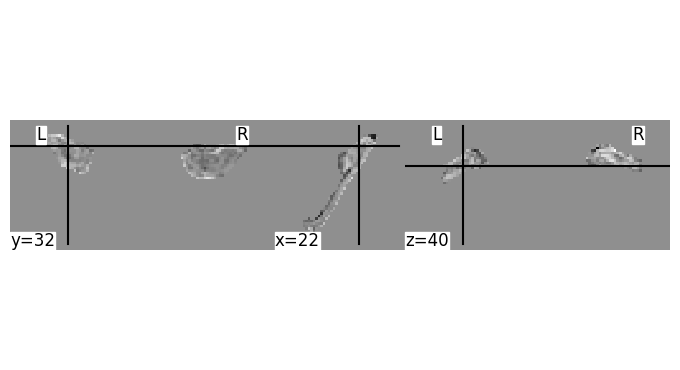

In [ ]:
loader = DataLoader(train_dataset, batch_size=16)
b = first(loader)

plotting.plot_img(
    nib.Nifti1Image(b['image'][0, 0, :, :, :].detach().cpu().numpy(), np.eye(4)), 
    cmap='gray'
)

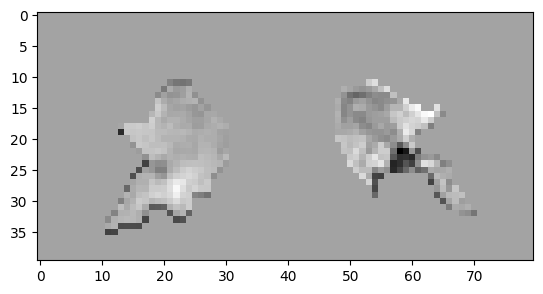

In [73]:
plt.imshow(b['image'][0, 0, :, 20, :].detach().cpu().numpy().T, cmap='gray')

## Models

In [25]:
from monai.networks.nets import DenseNet121, DenseNet169, DenseNet201, DenseNet264

- Set determinsm to allow reproducibility

In [ ]:
#torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

from monai.utils import set_determinism

set_determinism(seed=42)
# Setting a seed for reproducibility
set_seed(42)

- Define models
- Re-run the notebook with another model to check the result of the experiment on a different network

In [27]:
model = DenseNet121(
    spatial_dims=3, 
    in_channels=1,
    out_channels=3, 
    dropout_prob=.1,
)

- Define the He initialization

In [28]:
def he_initialization(module):
    g = torch.Generator()
    g.manual_seed(42)
    
    if isinstance(module, nn.Linear) or isinstance(module, nn.Conv3d):
        nn.init.kaiming_normal_(module.weight, mode='fan_in', nonlinearity='relu', generator=g)

In [29]:
model.apply(he_initialization)
model = model.to(get_device())

## Train the model


- Initialize the trainer object

In [ ]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-2)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

trainer = t.CustomTrainer(model, train_dataset, validation_dataset, optimizer, loss_function, False)
trainer.set_scheduling(scheduler)

- Launch the training

In [ ]:
out = trainer.train_model(
    100, 
    10,
    15,
    data_key_name='image', 
    data_label_name='label'
)

## Predictions on test set

In [23]:
test_dataset = CacheDataset(test_set_dict, **cache_settings)

In [24]:
test_loader = DataLoader(
                test_dataset, 
                batch_size=1, 
                shuffle=False, 
            )

In [25]:
y_true = []
y_pred = []
y_proba = []
data_key_name=['image', 'data']

model.eval()

with torch.no_grad():
    for b in test_loader:
        model_input = {k: v for k, v in zip(b.keys(), b.values()) if k in data_key_name}
        output_logit = model(b['image'])
        output = torch.argmax(output_logit, dim=1)
        
        y_proba.append(torch.nn.Softmax(dim=1)(output_logit)[0].detach().cpu())
        y_pred.append(output.detach().cpu().item())
        y_true.append(b['label'].item())

In [30]:
from sklearn.metrics import classification_report, roc_auc_score, ConfusionMatrixDisplay

In [31]:
print(classification_report(y_true, y_pred, labels=[0, 1], digits=3), )

              precision    recall  f1-score   support

           0      0.812     0.578     0.675        45
           1      0.424     0.700     0.528        20

    accuracy                          0.615        65
   macro avg      0.618     0.639     0.602        65
weighted avg      0.693     0.615     0.630        65



In [28]:
roc_auc_score(y_true, y_pred)

0.6388888888888888

## Save results to file

- Training results

In [34]:
out.to_csv('out.csv')

- Prediction results

In [35]:
import pickle

d = {'true': y_true, 'pred': y_pred, 'proba': y_proba}

with open('preds.pkl', 'wb') as f:
    pickle.dump(d, f)